<a href="https://colab.research.google.com/github/ueki5/colaboratory/blob/main/playground-018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install torchviz | tail -n 1
%pip install torchinfo | tail -n 1
%pip install torchvision | tail -n 1
%pip install japanize-matplotlib | tail -n 1
%pip install plotly | tail -n 1

cpu
訓練データの型： <class 'torch.Tensor'>
訓練データのshape： torch.Size([784])
最小値： tensor(-1.)
最大値： tensor(1.)
検証データの型： <class 'torch.Tensor'>
検証データのshape： torch.Size([784])
最小値： tensor(-1.)
最大値： tensor(1.)
inputs.shape: torch.Size([500, 784])
labels.shape: torch.Size([500])
n_input: 784, n_hidden: 128, n_output: 10
in=784, out=128
in=128, out=10
初期状態: 損失: 2.31900 精度: 0.09600
最終状態: 損失: 0.50598 精度: 0.87800


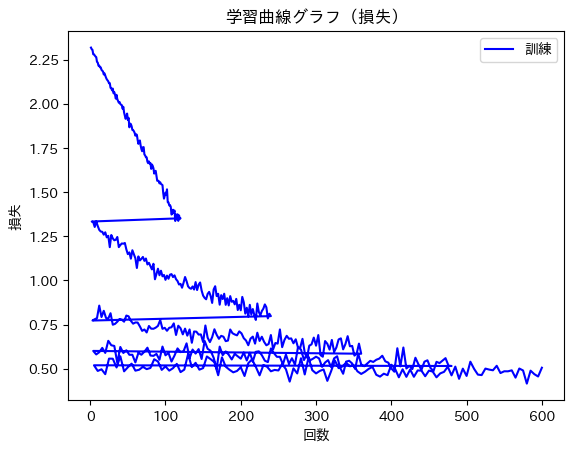

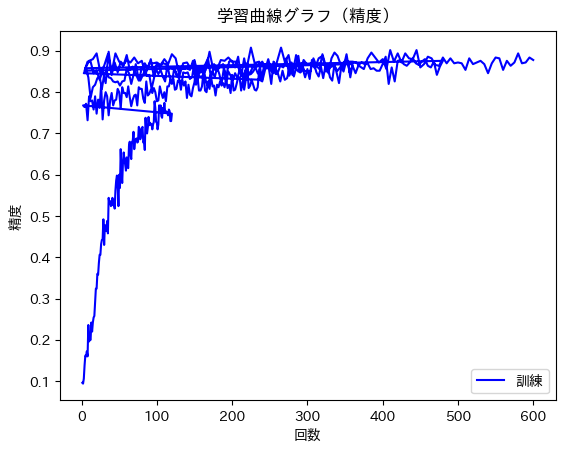

In [62]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import japanize_matplotlib
japanize_matplotlib.japanize()
from torch.utils.data import DataLoader

# 各種定数
batch_size = 500 # ミニバッチのサイズ指定
lr = 0.01  # 学習率
num_epochs = 5 # 繰り返し回数
# num_history = 10 # 履歴採取タイミング
dim_hidden = 128 # 隠れ層の次元数
dim_output = 10 # 出力層の次元数
num_layer = 2 # レイヤー数

# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# ダウンロード先ディレクトリ名
data_root = './data'

# # ReLU関数
# relu = torch.nn.ReLU()
# x_np = np.arange(-2, 2.1, 0.25)
# x = torch.tensor(x_np).float()
# y = relu(x)

# plt.plot(x.data, y.data)
# plt.title('ReLU関数')
# plt.show()

# # テスト用テンソル変数x, y
# x_np = np.arange(-2, 2.1, 0.25)
# y_np = np.arange(-1, 3.1, 0.25)
# x = torch.tensor(x_np).float()
# y = torch.tensor(y_np).float()

# # 変数xをGPUに送る
# x = x.to(device)
# y = y.to(device)

# # 変数xとyのdevice属性の確認
# print('x:', x.device)
# print('y:', y.device)

# # xとyの間の演算
# z = x * y
# print(z)

# train_set0 = datasets.MNIST(
#     # 元データダウンロード先の指定
#     root = data_root,
#     # 訓練データか検証データか
#     train = True,
#     # 元データがない場合にダウンロードするか
#     download = True)

# # ダウンロードしたファイルの確認
# !ls -lR ./data/MNIST

# # データ件数の確認
# print('train_set0.data.shape：', train_set0.data.shape)
# print('データ件数：', len(train_set0))

# # 最初の要素の取得
# image, label = train_set0[0]

# # データ型の確認
# print('入力データの型：', type(image))
# print('正解データの型：', type(label))
# print(f'image.format:{image.format}')
# print(f'image.size:{image.size}')
# print(f'image.mode:{image.mode}')
# print(f'image.getextrema:{image.getextrema()}')
# for i in range(image.size[0]):
#   for j in range(image.size[1]):
#     print(f'image.getpixel(({i},{j})):{image.getpixel((i, j))}')

# # 入力データの画像表示
# plt.figure(figsize=(1, 1))
# plt.title(f'{label}')
# plt.imshow(image, cmap='gray_r')
# plt.axis('off')
# plt.show()

# # 正解データ付きで、最初の２０個をイメージ表示
# plt.figure(figsize=(10, 3))
# for i in range(20):
#   ax = plt.subplot(2, 10, i + 1)

#   # imageとlabelの所得
#   image, label = train_set0[i]

#   # イメージ表示
#   plt.imshow(image, cmap='gray_r')
#   ax.set_title(f'{label}')
#   ax.get_xaxis().set_visible(False)
#   ax.get_yaxis().set_visible(False)
# plt.show()

# テンソル化 ＋ 正規化 ＋ １階テンソル化
transform = transforms.Compose([
  # データのテンソル化
  transforms.ToTensor(),
  # データの正規化(Normalize(μ, σ) ⇒ (x - μ) / σ)
  transforms.Normalize(0.5, 0.5),
  # １階テンソル化
  transforms.Lambda(lambda x: x.view(-1)),
])

# 訓練データ
train_set = datasets.MNIST(
  root=data_root,
  train=True,
  download=True,
  transform=transform
)

# 検証データ
test_set = datasets.MNIST(
  root=data_root,
  train=False,
  download=True,
  transform=transform
)
# 変換結果の確認
image, label = train_set[0]
print('訓練データの型：', type(image))
print('訓練データのshape：', image.shape)
print('最小値：', image.data.min())
print('最大値：', image.data.max())

image, label = test_set[0]
print('検証データの型：', type(image))
print('検証データのshape：', image.shape)
print('最小値：', image.data.min())
print('最大値：', image.data.max())

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(
    train_set,
    batch_size = batch_size,
    shuffle = True,
)

# 検証用データローダー
# 検証用にシャッフルは不要
test_loader = DataLoader(
    test_set,
    batch_size = batch_size,
    shuffle = False,
)

# 何組のデータが取得できるか？
num_data = len(train_loader)

# データローダーから最初の１セットを取得する
inputs, labels = next(iter(train_loader))
print('inputs.shape:', inputs.shape)
print('labels.shape:', labels.shape)

# 入力次元数
n_input = inputs.shape[1] # 0:ミニバッチサイズ、1:入力次元数

# 出力次元数
n_output = dim_output

# 隠れ層の次元数
n_hidden = dim_hidden

# 結果確認
print(f'n_input: {n_input}, n_hidden: {n_hidden}, n_output: {n_output}')

###################################################
# 関数定義
###################################################
class Net(torch.nn.Module):
    def __init__(self, n_input, n_output, n_hidden, n_layer):
        super().__init__()

        # リニア層の定義
        layers = []
        for i in range(n_layer):
            _n_input = n_hidden
            _n_output = n_hidden
            if i == 0:
                _n_input = n_input
            if i == n_layer - 1:
                _n_output = n_output
            print(f'in={_n_input}, out={_n_output}')
            layers.append(torch.nn.Linear(_n_input, _n_output))
        self.layers = torch.nn.ModuleList(layers)

        # ReLU関数
        self.relu = torch.nn.ReLU(inplace=True)

    # 予測関数
    def forward(self, inputs):
      x = self.layers[0](inputs)
      for layer in self.layers[1:]:
        x = self.relu(x)
        x = layer(x)
      return x

# 予測計算オブジェクトの作成
net = Net(n_input, n_output, n_hidden, num_layer)

# 損失関数
criterion = torch.nn.CrossEntropyLoss()

# 最適化関数
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 記録用配列初期化()
# 0:epoch
# 1:train_loss
# 2:train_acc
# 3:train_loss_test
# 4:train_acc_test
history = np.zeros((0, 5))

# 学習＆検証
for epoch in range(num_epochs):
  ###########################
  # 学習
  ###########################
  for idx, (inputs, labels) in enumerate(train_loader):
    # 予測計算
    outputs = net(inputs)

    # 損失計算
    loss = criterion(outputs, labels)

    # 勾配計算
    loss.backward()

    # パラメータ調整
    optimizer.step()

    # 勾配クリア
    optimizer.zero_grad()

    # 損失の保存（スカラー値の取得）
    train_loss = loss.item()

    # 予測データ（0, 1, ... ,9）計算
    predicted = torch.max(outputs, 1)

    # 精度計算
    train_acc = (predicted.indices == labels).sum() / len(labels)

  ###########################
  # 検証
  ###########################
  for idx, (inputs_test, labels_test) in enumerate(test_loader):
    # 予測計算
    outputs_test = net(inputs_test)

    # 損失計算
    loss_test = criterion(outputs_test, labels_test)

    # 勾配計算
    loss_test.backward()

    # パラメータ調整
    optimizer.step()

    # 勾配クリア
    optimizer.zero_grad()

    # 損失の保存（スカラー値の取得）
    train_loss_test = loss_test.item()

    # 予測データ（0, 1, ... ,9）計算
    predicted_test = torch.max(outputs_test, 1)

    # 精度計算
    train_acc_test = (predicted_test.indices == labels_test).sum() / len(labels_test)


    # 履歴を保存
    item = np.array([
      (idx + 1) * (epoch + 1),
      train_loss,
      train_acc,
      train_loss_test,
      train_acc_test,
    ])
    history = np.vstack((history, item))

    # デバッグ用
    if idx == num_data - 1:
      pass

###############################################
# 結果表示
###############################################
# 損失と精度の確認
print(f'初期状態: 損失: {history[0, 1]:.5f} 精度: {history[0, 2]:.5f}')
print(f'最終状態: 損失: {history[-1, 1]:.5f} 精度: {history[-1, 2]:.5f}')

# 学習曲線グラフ（損失）
plt.plot(history[:, 0], history[:, 1], 'b', label='学習')
plt.plot(history[:, 0], history[:, 3], 'k', label='検証')
plt.xlabel('回数')
plt.ylabel('損失')
plt.title('学習曲線グラフ（損失）')
plt.legend()
plt.show()

# 学習曲線グラフ（精度）
plt.plot(history[:, 0], history[:, 2], 'b', label='学習')
plt.plot(history[:, 0], history[:, 4], 'k', label='検証')
plt.xlabel('回数')
plt.ylabel('精度')
plt.title('学習曲線グラフ（精度）')
plt.legend()
plt.show()

